In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import pickle
import random
import math
import time

import nltk
from nltk.tokenize import sent_tokenize

import re

from tqdm import tqdm

import wandb

import torch.utils.data as data
from torch.utils.data import Dataset

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


### Global variables

In [3]:
LMAX = 40

attentionNetworkBool = 1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Get the data

You have to adpt the path to your computer

The data can be downloaded there https://www.kaggle.com/code/apekshakom/sentiment-analysis-of-restaurant-reviews

In [5]:
file_path = '/home/jpierre/other/sentiment_analyzis/data/a1_RestaurantReviews_HistoricDump.tsv'

d = pd.read_csv(file_path, delimiter = '\t', quoting = 3)



In [6]:
d.head(5)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [7]:
df = d['Review'].values
y = d['Liked'].values
print(df[2])

Not tasty and the texture was just nasty.


In [8]:
labelDict = {}
labelDict[0] = 'dislike'
labelDict[1] = 'like'

## Exploring data

1) Length of our sentences

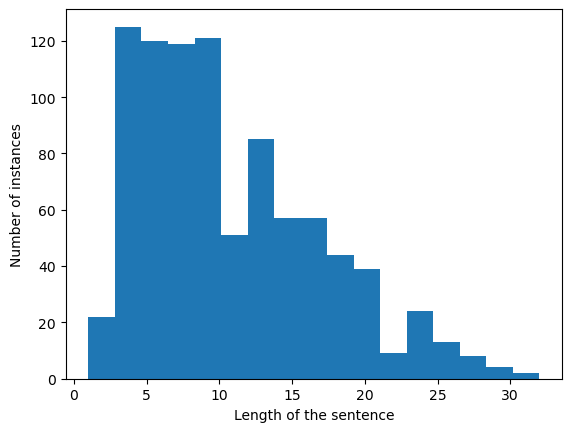

900


In [9]:
def getLength(data:list, display:bool = True)->list:
    """ 
    Function to get the distribution of the lengths of the sentences in 
    our data
    
    Args:
    -----
    - `data`: list with the sentences
    - `display`(optional): boolean to set the plot of the histogram
    
    Output:
    -------
    the list of lengths
    """
    L = [len(data[i].split(' ')) for i in range(len(data))]

    if display:
        plt.hist(L, bins='auto')
        plt.xlabel('Length of the sentence')
        plt.ylabel('Number of instances')
        plt.savefig('hist.png')
        plt.show()
    return L

L = getLength(df)
print(len(L))

The sentences have quite diverse lengths but the mean is a bit small compared to other datasets

2) Repartition of the labels

In [10]:
def getNb(labelData:list, labelDict:dict = labelDict, display:bool = True)->np.array:
    """
    Function to count the number of instances per label
    
    Args:
    -----
    - `labelData`: list of labels
    - `labelDict`: dictionnary of the labels
    - `display`(optional): boolean to activate the display
    
    Output:
    ------
    - vector wiht counts
    """

    countVect = np.zeros(len(labelDict)).astype(int)

    for i in range(len(labelData)):
        label = labelData[i]
        countVect[label] += 1

    if display:
        plt.bar(['Disliked', 'Liked'], countVect)
        plt.ylabel('Number of instances')
        plt.savefig('bar.png')
        plt.show()

    return countVect

{0: 'dislike', 1: 'like'}


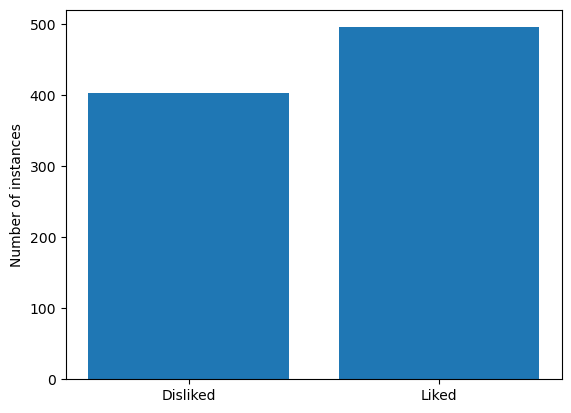

[404 496]


In [11]:
print(labelDict)
nb = getNb(d['Liked'])


print(nb)

In this case we are happy since the dataset seems to be balanced.

## Preprocessing step

1) contraction (dealing with I'm, I'd, ...)

2) uppercase letters -> lowercase letters

3) get rid of stopwords

4) remove punctiation, numbers

5) dealing with spaces

In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
import contractions

stopWords.remove('not')
stopWords.remove('i')
stopWords.remove('you')
stopWords.remove('he')
stopWords.remove('she')
stopWords.remove('it')
stopWords.remove('we')
stopWords.remove('they')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jpierre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def preprocess(sentences:list[str], stopWords)->list:
    """
    Function to apply all the preprocessing
    
    Args:
    -----
    - `sentences`: list of sentences
    - `stopWords`: stopwords to handle
    
    Output:
    -------
    the list with the preprocessed sentences
    """
    
    res = []
    for sentence in tqdm(sentences):
        
        ## 1
        sentence = contractions.fix(sentence)
        
        ## 2
        sentence = sentence.lower()
        
        ## 3
        pattern = re.compile(r'\b(' + r'|'.join(stopWords) + r')\b\s*')
        sentence = pattern.sub('', sentence)

        ## 4
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        ## 5
        sentence = re.sub(r'\s+', ' ', sentence)
        sentence = sentence.strip()

        res.append(sentence)

    return res


In [14]:
print(df[:15])

['Wow... Loved this place.' 'Crust is not good.'
 'Not tasty and the texture was just nasty.'
 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.'
 'The selection on the menu was great and so were the prices.'
 'Now I am getting angry and I want my damn pho.'
 "Honestly it didn't taste THAT fresh.)"
 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.'
 'The fries were great too.' 'A great touch.' 'Service was very prompt.'
 'Would not go back.'
 'The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.'
 'I tried the Cape Cod ravioli, chicken, with cranberry...mmmm!'
 'I was disgusted because I was pretty sure that was human hair.']


In [15]:
df = preprocess(df, stopWords)

100%|██████████| 900/900 [00:00<00:00, 26155.01it/s]


In [16]:
print(df[:15])

['wow loved place', 'crust not good', 'not tasty texture nasty', 'stopped late may bank holiday rick steve recommendation loved it', 'selection menu great prices', 'i getting angry i want damn pho', 'honestly it not taste fresh', 'potatoes like rubber you could tell they made ahead time kept warmer', 'fries great', 'great touch', 'service prompt', 'would not go back', 'cashier care ever i say it still ended wayyy overpriced', 'i tried cape cod ravioli chicken cranberry mmmm', 'i disgusted i pretty sure human hair']


### We can now decompose the sentences by spliting the spaces

In [17]:
def decompose(df:list[str])->list:
    """ 
    Function to decompose the sentences according to the spaces
    
    Args:
    -----
    - `df`: list of preprocessed sentences
    
    Output:
    -------
    list with the sentences decomposed according to spaces
    """
    
    for i in tqdm(range(len(df))):
        df[i] = df[i].split(' ')
    return df

df = decompose(df)


100%|██████████| 900/900 [00:00<00:00, 605918.72it/s]


In [18]:
print(max([len(df[i]) for i in range(len(df))]))

21


In [19]:
# can update LMAX

LMAX = 30

## Word embeddings

### Word2Vec

In [35]:
EMB_SIZE =300   # size of the embeddings

In [41]:
import gensim.downloader as api

word2vecModel = api.load('word2vec-google-news-300')

In [44]:
def getW2VTextEmb(words:list[str], model = word2vecModel)->torch.tensor:
    """
    Function to apply the word2Vec on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """
    defaultVector = np.ones(EMB_SIZE)
    
    res = []
    for word in words:
        try:
            res.append(torch.from_numpy(model[word]))
        except:
            res.append(torch.from_numpy(defaultVector))
        
    return torch.stack(res)

def sentences2W2VEmbs(sentences:list[str])->torch.tensor:
    """
    Function to apply the word2Vec on sentences
    
    Args:
    -----
    - `sentence`: sentences on which to apply the embeddings

    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros((len(sentences), LMAX, EMB_SIZE))
    
    for i in range(len(sentences)):
        sentence = sentences[i]
        
        embs = getW2VTextEmb(sentence)  # [l, embs]
        l = embs.shape[0]
        matrix[i, :l, :] = embs
        
    return matrix

def simpleSentences2W2VEmbs(sentence)->torch.tensor:
    """
    Function to apply the word2Vec on sentences
    
    Args:
    -----
    - `sentence`: sentence on which to apply the embeddings
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros( LMAX, EMB_SIZE)
    
    embs = getW2VTextEmb(sentence)  # [l, embs]
    l = embs.shape[0]
    matrix[:l, :] = embs
        
    return matrix

In [45]:
print(sentences2W2VEmbs(df)[2][7].shape)

# some errors in the text that had to be handled for it to work (before setting a default vector)
# honelty - > honetly
# ravoli ->ravioli
# burritos -> dish
# place "excalibur" -> city 
# spelling mistakes == > beateous - > beauteous
# Bussell Sprouts =>Brussells Sprouts
# veggitarian --> vegetarian
# andddd
# name of the place "Steiners" --> this place
# gooodd
# smashburger

torch.Size([300])


### GloVe

In [20]:
EMB_SIZE =300      # size of the embeddings

In [21]:
from torchtext.vocab import GloVe

glove = GloVe(name='6B', dim=EMB_SIZE, unk_init = torch.Tensor.normal_)

In [22]:
def getGloveTextEmb(words, model = glove):
    """
    Function to apply the word2Vec on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """

    res = [model[word] for word in words]
    
    return torch.stack(res)

def sentences2GloveEmbs(sentences):
    """
    Function to apply the Glove on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros((len(sentences), LMAX, EMB_SIZE))
    
    for i in range(len(sentences)):
        sentence = sentences[i]
        
        embs = getGloveTextEmb(sentence)  # [l, embs]
        l = embs.shape[0]
        matrix[i, :l, :] = embs
        
    return matrix

def simpleSentences2GloveEmbs(sentence):
    """
    Function to apply the Glove on sentences
    
    Args:
    -----
    - `sentence`: sentence on which to apply the embeddings
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros( LMAX, EMB_SIZE)
    
    embs = getGloveTextEmb(sentence)  # [l, embs]
    l = embs.shape[0]
    matrix[:l, :] = embs
        
    return matrix

### fasttext

In [58]:
EMB_SIZE = 300        # size of the embeddings

In [59]:
import fasttext
from torchtext.vocab import FastText


fastTextEng = FastText(language='en', unk_init = torch.Tensor.normal_)
            

In [60]:
def getFastTextEmb(words, model = fastTextEng):
    """
    Function to apply the word2Vec on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """

    res = [model[word] for word in words]
    
    return torch.stack(res)

def sentences2FastTextEmbs(sentences):
    """
    Function to apply the FastText on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros((len(sentences), LMAX, EMB_SIZE))
    
    for i in range(len(sentences)):
        sentence = sentences[i]
        
        embs = getFastTextEmb(sentence)  # [l, embs]
        l = embs.shape[0]
        matrix[i, :l, :] = embs
        
    return matrix

def simpleSentences2FastTextEmbs(sentence):
    """
    Function to apply the FastText on sentences
    
    Args:
    -----
    - `sentence`: sentence on which to apply the embeddings
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros( LMAX, EMB_SIZE)
    
    embs = getFastTextEmb(sentence)  # [l, embs]
    l = embs.shape[0]
    matrix[:l, :] = embs
        
    return matrix

### Global function

In [46]:
EMBTYPE = 'GloVe'

In [47]:
def getEmbedding(sentences, method = EMBTYPE):

    if method == 'Word2Vec':
        embs = simpleSentences2W2VEmbs(sentences)
    
    if method == 'GloVe':
        embs = simpleSentences2GloveEmbs(sentences)

    if method == 'fasttext':
        #embs = sentences2FastTextEmbs(sentences)
        embs = simpleSentences2FastTextEmbs(sentences)
    return embs

## Model

1) simple GRU model

In [48]:
class MLP2(nn.Module):
    def __init__(self, inputShape:int, outputShape:int, dropout:float = 0.3):
        super(MLP2, self).__init__()

        self.dropout = dropout
        self.inputShape = inputShape
        self.outputShape = outputShape

        self.delta = (inputShape - outputShape) // 3
        dim1 = inputShape - self.delta
        dim2 = dim1 - self.delta

        self.mlp = nn.Sequential(
            nn.Linear(inputShape, dim1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(dim1, dim2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(dim2, outputShape),
        )
    
    def forward(self, x):
        x = self.mlp(x)
        return x

In [49]:
class SimpleGRUClassifier(nn.Module):
    def __init__(self, inputSize, hiddenSize, stateSize, outputSize):
        super(SimpleGRUClassifier, self).__init__()

        self.InMlp = MLP2(inputSize, hiddenSize)       # to bring the embedding to a same dimension

        self.gru = nn.GRU(input_size=hiddenSize, 
                          hidden_size=stateSize, 
                          num_layers=1, 
                          bidirectional=True, 
                          batch_first=True)

        self.outMlp = MLP2(stateSize*2*LMAX, outputSize)  # to bring everything outside of the NN

        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        
        x = self.InMlp(x)
        

        output, _ = self.gru(x)   # [N, L, 2*hiddenSize]
        

        output = self.outMlp(output.reshape(output.shape[0], -1))
                
        return output

In [50]:
class SelfAttention(nn.Module):
    def __init__(self, inputShape:int, outputShape:int):
        """ 
        Args:
        -----
        - `inputShape`: shape of the input
        - `outputShape`: shape of the output (second shape of the value matrix)
        """
        
        super(SelfAttention, self).__init__()
        
        self.inputShape = inputShape
        self.outputShape = outputShape
        
        # matrices for the Q, K, V
        self.W_q = nn.Linear(inputShape, inputShape)
        self.W_k = nn.Linear(inputShape, inputShape)
        self.W_v = nn.Linear(inputShape, outputShape)
        
    def forward(self, x):
        """ 
        Args:
        -----
        - `x`: tensor [N, L, inputShape]
        """
        # Obtainng Q, K, V
        Q = self.W_q(x)   # [N, L, inputShape]
        K = self.W_k(x)   # [N, L, inputShape]
        V = self.W_v(x)   # [N, L, outputShape]
        
        scores = torch.bmm(Q, K.transpose(-2,-1)) / torch.sqrt(torch.tensor(self.inputShape).float())      # [N, L, L]
        
        weights = F.softmax(scores, dim=-1)       # [N, L, L]
        
        out = torch.bmm(weights, V)        # [N, L, outputShape]
        
        return out, weights
    


class AttentionGRUClassifier(nn.Module):
    def __init__(self, inputSize, hiddenSize, stateSize, outputSize):
        super(AttentionGRUClassifier, self).__init__()

        self.InMlp = MLP2(inputSize, hiddenSize)       # to bring the embedding to some given dimension

        self.gru = nn.GRU(input_size=hiddenSize, 
                          hidden_size=stateSize, 
                          num_layers=1, 
                          bidirectional=True, 
                          batch_first=True)
        
        self.attentionLayer = SelfAttention(2*stateSize, 2*stateSize)  #*2 because of the bidirectionnal GRU

        self.outMlp = MLP2(stateSize*2*LMAX, outputSize)  # to bring everything outside of the NN

    def forward(self, x):
                
        x = self.InMlp(x)

        output, _ = self.gru(x)   # [N, L, 2*hiddenSize]
        
        
        output, weights = self.attentionLayer(output)

        output = self.outMlp(output.reshape(output.shape[0], -1))
                
        return output, weights

## Dataset Class

In [28]:
class textDatasets(Dataset):
    """
    Class to generate data tuples for learning
    """

    def __init__(self, langList:list[list[str]], y:list[int]):
        """ 
        Args:
        -----
        - `langList`: list of the sentences
        - `y`: list of labels
        """

        self.langList = langList
        self.y = y
        self.length = len(langList)


    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        
        s = getEmbedding(self.langList[idx])
        y = self.y[idx]
        
        return s, y

In [29]:
L = int(0.7*len(df))
dfTrain = df[:L]
dfTest = df[L:]

y = d['Liked'].values
yTrain = y[:L]
yTest = y[L:]

nbBatch = 50

datasetLearning = textDatasets(langList=dfTrain, y = yTrain)
datasetTest = textDatasets(langList=dfTest, y = yTest)

loaderLearning = data.DataLoader(datasetLearning, batch_size = nbBatch, shuffle= True, num_workers = 1)
loaderTest = data.DataLoader(datasetTest, batch_size = nbBatch, shuffle= True, num_workers = 1)


## Training

In [30]:
inputShape = EMB_SIZE
hiddenShape = 128
hiddenStatesShape = 128
outputShape = len(labelDict)

if attentionNetworkBool:
    NN = AttentionGRUClassifier(inputShape, hiddenShape, hiddenStatesShape, outputShape).to(device)
else:
    NN = SimpleGRUClassifier(inputShape, hiddenShape, hiddenStatesShape, outputShape).to(device)


In [31]:

def getAccuracy(out, gtruth):
    """
    Function to get the accuracy
    
    Args:
    -----
    - `out`: prediction of the neural network
    - `gtruth`: ground truths
    
    Ouptut:
    -------
    number of correctly classified instances
    """
    
    gtruth = gtruth.reshape(-1)
    _, i = out.topk(1, dim=-1)
    i = i.reshape(-1)
    return torch.sum(i == gtruth)


In [32]:
nbEpoch=200
loaderLearning = loaderLearning
loaderValidation = loaderTest
loaderTest = loaderTest
decay = .00001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(NN.parameters(), lr=0.005, weight_decay=5e-4)

/home/jpierre/anaconda3/envs/myenvPy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
wandb.init(project = 'master_thesis', name = "sentiment_ana_w2v_attention_simple_data")
wandb.watch(NN, log = 'all', log_freq=500)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jepi1202 (uliege_action_spotting_2022_2023_context). Use `wandb login --relogin` to force relogin


[]

In [34]:
def train():

    j = 0
    max_valid = float('-inf')

    for i in range(nbEpoch):

        NN.train()

        for x, y in tqdm(loaderLearning):
            
           
            x = x.to(device)
            y = y.to(device)

            if attentionNetworkBool:
                out, _ =  NN(x)
            else:
                out =  NN(x)

            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if ((j+1) % 1) == 0:
                
                max_param_value = max(torch.max(torch.abs(param)).item() for param in NN.parameters())

                max_grad_value = max(torch.max(torch.abs(param.grad)).item() for param in NN.parameters() if param.grad is not None)
                
                
                wandb.log({'epoch': i, 'Training Loss': loss, 'max param': max_param_value, 'max grad': max_grad_value})


            if ((j+1) % 50) == 0:
                NN.eval()
                
                with torch.no_grad():
                    
                    # training accuracy
                    trainAcc = 0
                    for x, y in loaderLearning:
           
                        x = x.to(device)
                        y = y.to(device)

                        if attentionNetworkBool:
                            out, _ =  NN(x)
                        else:
                            out =  NN(x)
                    
                        trainAcc += getAccuracy(out, y)
                        
                    wandb.log({'epoch': i, 'training accuracy': trainAcc / len(datasetLearning)})

                                         
                    
                NN.train()
                
                if attentionNetworkBool:
                    torch.save(NN.state_dict(), "mod_w2v_attention_simp.pt")
                else:
                    torch.save(NN.state_dict(), "mod_w2v_simp.pt")

            j += 1
            
if __name__ == "__main__":

    train()

100%|██████████| 13/13 [00:00<00:00, 23.24it/s]


KeyboardInterrupt: 

## Analyzing the results

In [51]:
sd = torch.load('/home/jpierre/other/sentiment_analyzis/mod_w2v_best_attention_simp.pt')
NN.load_state_dict(sd)
NN = NN.to(device)
NN.eval()

AttentionGRUClassifier(
  (InMlp): MLP2(
    (mlp): Sequential(
      (0): Linear(in_features=300, out_features=243, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=243, out_features=186, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=186, out_features=128, bias=True)
    )
  )
  (gru): GRU(128, 128, batch_first=True, bidirectional=True)
  (attentionLayer): SelfAttention(
    (W_q): Linear(in_features=256, out_features=256, bias=True)
    (W_k): Linear(in_features=256, out_features=256, bias=True)
    (W_v): Linear(in_features=256, out_features=256, bias=True)
  )
  (outMlp): MLP2(
    (mlp): Sequential(
      (0): Linear(in_features=7680, out_features=5121, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=5121, out_features=2562, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=256

In [52]:
preds = None
y = None
for x_test, y_test in loaderTest:
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    if attentionNetworkBool:
        out, _ =  NN(x_test)
    else:
        out =  NN(x_test)
    
    if preds is None:
        preds = out
    else:
        preds = torch.vstack((preds, out))
        
    if y is None:
        y = y_test.reshape(-1)
    else:
        y = torch.concat((y.reshape(-1), y_test.reshape(-1)))


In [53]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('conf_mat.png')
    plt.show()


In [54]:
y = y.cpu().numpy()
_, i = preds.topk(1, dim = -1)
predictions = i.reshape(-1).cpu().numpy()

[[104  19]
 [ 16 131]]


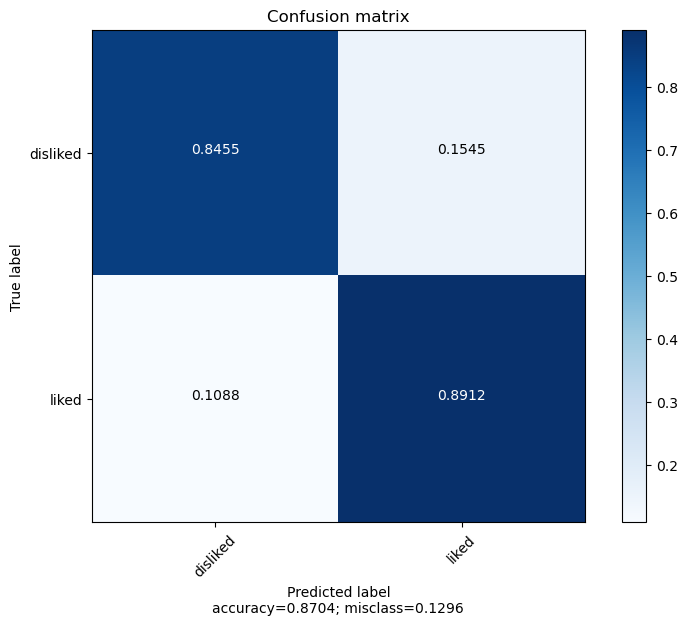

In [55]:
from sklearn.metrics import confusion_matrix
import itertools

conf_matrix = confusion_matrix(y, predictions)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, ['disliked', 'liked'], normalize=True)

### Attention weights matrix

In [56]:
print(d['Review'][42])
print(d['Liked'][42])

Hard to judge whether these sides were good because we were grossed out by the melted styrofoam and didn't want to eat it for fear of getting sick.
0


In [57]:
sentence = df[42]
print(sentence)

['hard', 'judge', 'whether', 'sides', 'good', 'we', 'grossed', 'melted', 'styrofoam', 'not', 'want', 'eat', 'it', 'fear', 'getting', 'sick']


In [58]:
NN.eval()

AttentionGRUClassifier(
  (InMlp): MLP2(
    (mlp): Sequential(
      (0): Linear(in_features=300, out_features=243, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=243, out_features=186, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=186, out_features=128, bias=True)
    )
  )
  (gru): GRU(128, 128, batch_first=True, bidirectional=True)
  (attentionLayer): SelfAttention(
    (W_q): Linear(in_features=256, out_features=256, bias=True)
    (W_k): Linear(in_features=256, out_features=256, bias=True)
    (W_v): Linear(in_features=256, out_features=256, bias=True)
  )
  (outMlp): MLP2(
    (mlp): Sequential(
      (0): Linear(in_features=7680, out_features=5121, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=5121, out_features=2562, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=256

In [59]:
embs = getEmbedding(sentence).to(device)
out, w = NN(embs[None, :, :])

In [60]:
print(F.softmax(out, dim = -1))

tensor([[1.0000e+00, 1.2170e-10]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_1543117/4099214742.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [w for w in sentence])
/tmp/ipykernel_1543117/4099214742.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [w for w in sentence])


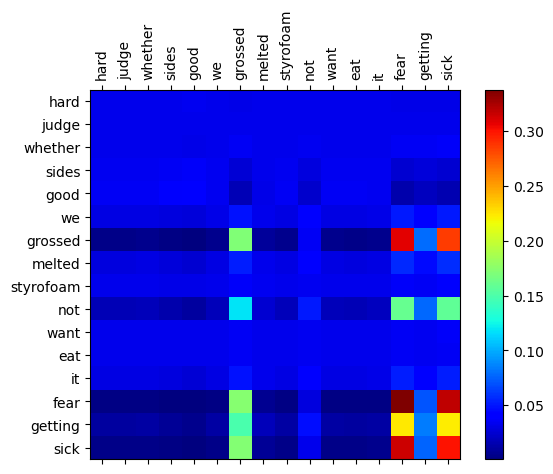

In [61]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()

cax = ax.matshow(w.cpu().detach().numpy()[0, :len(sentence), :len(sentence)], cmap='jet')
plt.colorbar(cax)

ax.set_xticklabels([''] + [w for w in sentence])
ax.set_yticklabels([''] + [w for w in sentence])

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

for tick in ax.get_xticklabels():
    tick.set_rotation(90)